In [1]:
import matplotlib.pyplot as plt
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from torch.utils.data import Dataset, DataLoader, RandomSampler
import torch
import requests
from bs4 import BeautifulSoup
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy
import pandas as pd
%pip install pandas
%pip install spotipy
%pip install bs4
%pip install torch
%pip install transformers

% matplotlib inline


torch.manual_seed(413)


C:\Users\caoki\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\caoki\AppData\Local\Programs\Python\Python37\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\caoki\AppData\Local\Programs\Python\Python37\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\caoki\AppData\Local\Programs\Python\Python37\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\caoki\AppData\Local\Programs\Python\Python37\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\caoki\AppData\Local\Programs\Python\Python37\python.exe -m pip install --upgrade pip' command.
UsageError: Line magic function `%` not found.


In [2]:
cid = '5c2034b1ae67482c8e309a15b8301688'
secret = '2012b40e3aad47c68743b538f92f378e'

client_credentials_manager = SpotifyClientCredentials(
    client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)


# Retrieving the Data


In [3]:
# Helper functions

# Getting artist and song titles
def get_album_tracks(uri_info):
    titles = []
    artists = []
    one = sp.playlist_tracks(uri_info, limit=100, offset=0, market='US')
    df1 = pd.DataFrame(one)

    for i, x in df1['items'].items():
        track = x['track']
        titles.append(track['name'])
        artists.append(track['artists'][0]['name'])

    df2 = pd.DataFrame({'title': titles, 'artist': artists})

    return df2

# Get lyrics using the Genius API


def scrape_lyrics(artistname, songname):
    artistname2 = str(artistname.replace(' ', '-')
                      ) if ' ' in artistname else str(artistname)
    songname2 = str(songname.replace(' ', '-')
                    ) if ' ' in songname else str(songname)
    page = requests.get('https://genius.com/' +
                        artistname2 + '-' + songname2 + '-' + 'lyrics')
    html = BeautifulSoup(page.text, 'html.parser')

    lyrics1 = html.find("div", class_="lyrics")
    lyrics2 = html.find("div", class_="Lyrics__Container-sc-1ynbvzw-6 jYfhrf")
    if lyrics1:
        lyrics = lyrics1.get_text()
    elif lyrics2:
        lyrics = lyrics2.get_text()
    elif lyrics1 == lyrics2 == None:
        lyrics = None

    lines = []
    for div in html.findAll('div', {'class': 'Lyrics__Container-sc-1ynbvzw-6 jYfhrf'}):
        lines.extend([text if text[0] !=
                      '[' else '\n' for text in div.stripped_strings])

    lyrics = ""
    for line in lines:
        if line != '\n':
            lyrics += line + '\n'

    return lyrics

# Clean and format dataframe with artists, titles, and lyrics


def format_data(tracks_data):
    lyrics_data = []
    for index, row in tracks_data.iterrows():
        song = scrape_lyrics(row['artist'], row['title'])
        if song != '':
            lyrics_data.append(song)
        elif song == '':
            tracks_data = tracks_data.drop(index)

    tracks_data = tracks_data.reset_index(drop=True)
    lyrics_df = pd.DataFrame({
        'lyrics': lyrics_data
    })

    result_df = tracks_data.merge(lyrics_df, left_index=True, right_index=True)

    return result_df


In [4]:
# Loading tracks from various love song playlists on Spotify
tracks1 = get_album_tracks('spotify:playlist:37i9dQZF1DWXqpDKK4ed9O')
data1 = format_data(tracks1)

tracks2 = get_album_tracks('spotify:playlist:2dcBq49u1O05UfOYp7IliA')
data2 = format_data(tracks2)

tracks3 = get_album_tracks('spotify:playlist:1k1OMvzbPSRzG2Dt5kJXay')
data3 = format_data(tracks3)

tracks4 = get_album_tracks('spotify:playlist:37i9dQZF1DXc3KygMa1OE7')
data4 = format_data(tracks4)

frames = [data1, data2, data3, data4]

df = pd.concat(frames)

# Filter duplicate songs because we used multiple playlists
df = df.drop_duplicates()

# Check
print(df.head())
lyrics_data = df['lyrics']


                 title          artist  \
0   I Knew I Loved You   Savage Garden   
1        How Do I Live     LeAnn Rimes   
2          Back At One  Brian McKnight   
3  From This Moment On    Shania Twain   
4            Sometimes  Britney Spears   

                                              lyrics  
0  Maybe it's intuition\nBut some things you just...  
1  How do I get through one night without you?\nI...  
2  It's undeniable\nThat we should be together\nI...  
3  I do swear that I'll always be there\nI'd give...  
4  You tell me you're in love with me\nLike you c...  


# GPT-2 Tokenizer

I'm using the Huggingface transformers library on the lyrics data to fine-tune the GPT2 model in order to generate song lyrics.


In [5]:
# Load GPT tokenizer
tokenizer = GPT2Tokenizer.from_pretrained(
    'gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>')


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
# Exploring the GPT2 tokenizer
# GPT-2 cannot work with strings directly. We need to tokenize each string, turning it into a list of numbers/tokens instead
test_sentence = "I love this computer science class"
input_ids = tokenizer.encode(test_sentence, return_tensors='pt')

test_sentence2 = "I love puppies"
input_ids2 = tokenizer.encode(test_sentence2, return_tensors='pt')

print(input_ids)
input_ids2


tensor([[  40, 1842,  428, 3644, 3783, 1398]])


tensor([[   40,  1842, 37793]])

# PyTorch Dataset and Dataloaders


In [7]:
# Keeping the batch size at 2 to avoid out of memory errors because GPT2 is a large model
batch_size = 2

# Lyrics will truncate without the eos token if it is longer than 1024 tokens
max_length = max([len(tokenizer.encode(lyric))
                  for lyric in lyrics_data])

print(max_length)


Token indices sequence length is longer than the specified maximum sequence length for this model (1064 > 1024). Running this sequence through the model will result in indexing errors


1255


In [8]:
# Custom dataset class with PyTorch
class LyricsDataset(Dataset):

    def __init__(self, lyrics_data, tokenizer, max_length=768):

        self.tokenizer = tokenizer
        self.input_ids = []
        self.attn_masks = []

        for lyrics in lyrics_data:
            # Wrap each of the lyrics in bos and eos tokens
            # Pad if less than max_length tokens and truncate without eos token if longer than max_length tokens
            encodings_dict = tokenizer('<|startoftext|>' + lyrics + '<|endoftext|>',
                                       truncation=True, max_length=max_length, padding="max_length")

            self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
            self.attn_masks.append(torch.tensor(
                encodings_dict['attention_mask']))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx]


In [9]:
dataset = LyricsDataset(lyrics_data, tokenizer, max_length=768)

# Selects batches randomly and trains with a batch size of 2
train_dataloader = DataLoader(
    dataset, sampler=RandomSampler(dataset), batch_size=batch_size)


# Finetuning GPT-2


In [10]:
# Load model
configuration = GPT2Config.from_pretrained(
    'gpt2', output_hidden_states=False)
model = GPT2LMHeadModel.from_pretrained('gpt2', config=configuration)

# Necessary because we've added new bos and eos tokens
model.resize_token_embeddings(len(tokenizer))


Embedding(50259, 768)

In [11]:
# Function to train
def train(dataloader, model, epochs, learning_rate, warmup_steps, epsilon):

    training_stats = []

    total_steps = len(dataloader) * epochs

    optimizer = AdamW(model.parameters(),
                      lr=learning_rate,
                      eps=epsilon
                      )

    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=warmup_steps,
                                                num_training_steps=total_steps)

    for epoch in range(0, epochs):

        print(f'======== Epoch {epoch + 1} / {epochs} ========')

        total_train_loss = 0

        model.train()

        for step, batch in enumerate(dataloader):

            b_input_ids = batch[0]
            b_labels = batch[0]
            b_masks = batch[1]

            model.zero_grad()

            outputs = model(b_input_ids,
                            labels=b_labels,
                            attention_mask=b_masks,
                            token_type_ids=None
                            )

            loss = outputs[0]

            batch_loss = loss.item()
            total_train_loss += batch_loss

            # Backward pass
            loss.backward()
            optimizer.step()

            scheduler.step()

        # Average training loss across a single batch
        avg_train_loss = total_train_loss / len(train_dataloader)

        print("Average training loss: {0:.2f}".format(avg_train_loss))

        training_stats.append(
            {
                'Epoch': epoch + 1,
                'Training Loss': avg_train_loss
            }
        )

    return model, training_stats


In [12]:
model, training_stats = train(
    train_dataloader, model, epochs=10, learning_rate=0.0005, warmup_steps=100, epsilon=1e-8)

# Display average training loss for each epoch
results = pd.DataFrame(training_stats)
results = results.set_index('Epoch')
results


C:\Users\caoki\AppData\Local\Programs\Python\Python37\lib\site-packages\transformers\optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


======== Epoch 1 / 10 ========
Average training loss: 5.94
======== Epoch 2 / 10 ========
Average training loss: 1.25
======== Epoch 3 / 10 ========
Average training loss: 1.12
======== Epoch 4 / 10 ========
Average training loss: 1.04
======== Epoch 5 / 10 ========
Average training loss: 0.98
======== Epoch 6 / 10 ========
Average training loss: 0.93
======== Epoch 7 / 10 ========
Average training loss: 0.88
======== Epoch 8 / 10 ========
Average training loss: 0.84
======== Epoch 9 / 10 ========
Average training loss: 0.81
======== Epoch 10 / 10 ========
Average training loss: 0.79


,Training Loss
Epoch,
1,5.936393
2,1.247347
3,1.121989
4,1.041597
5,0.976653
6,0.926351
7,0.882852
8,0.844295
9,0.811872


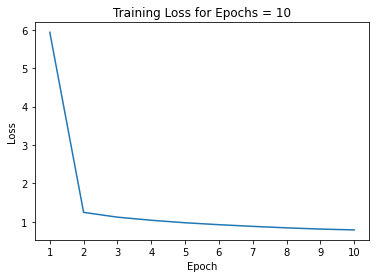

In [19]:
# Plot training loss
plt.plot(results['Training Loss'])
plt.title('Training Loss for Epochs = 10')
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

plt.show()


# Let's Crank Some Tunes


In [14]:
def generate_lyrics(prompt, top_p, top_k, num_return_sequences, max_length):

    model.eval()

    generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)

    outputs = model.generate(generated, do_sample=True, top_k=top_k, max_length=max_length,
                             top_p=top_p, num_return_sequences=num_return_sequences)

    for i, output in enumerate(outputs):
        print(
            f"======= Output {i+1}: ========\n{tokenizer.decode(output, skip_special_tokens=True)}\n\n")


In [24]:
generate_lyrics(prompt="<|startoftext|>", top_p=0.95, top_k=50,
                num_return_sequences=2, max_length=300)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


======= Output 1: ========
There's no place like home
And there's nothing to see, no one to hold
You can breathe again, you can feel the touch of my skin
Even the sweet, warm days fade away
Thoughts of you stay
And I still want you
To hold on
And make it real
In my life, I'll be true to myself
I'll never make it a question of my love
You're everything I've dreamed of
But now you're gone
And my spirit is dead
With no trace of hope
And you can never see, no one to hold
You can breathe again, you can feel the touch of my skin
Even the sweet, warm days fade away
Thoughts of you stay
And I still want you
To hold on
And make it real
In my life, I'll be true to myself
I'll never make it a question of my love
You're everything I've dreamed of
But now you're gone
And my spirit is dead
With no trace of hope
And you can never see, no one to hold
You can breathe again, you can feel the touch of my skin
Even the sweet, warm days fade away
Thoughts of you stay
And I still want you
To hold on
And mak